<h1>GIWAXS analysis using pyFAI<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Manual-for-this-notebook" data-toc-modified-id="Manual-for-this-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Manual for this notebook</a></span></li><li><span><a href="#Python-imports" data-toc-modified-id="Python-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python imports</a></span></li><li><span><a href="#Load-images" data-toc-modified-id="Load-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load images</a></span></li><li><span><a href="#Beam-parameters" data-toc-modified-id="Beam-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Beam parameters</a></span></li><li><span><a href="#Conversion-to-q-space" data-toc-modified-id="Conversion-to-q-space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conversion to q-space</a></span></li><li><span><a href="#Powder-plot" data-toc-modified-id="Powder-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Powder plot</a></span></li><li><span><a href="#2D-integration" data-toc-modified-id="2D-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>2D integration</a></span></li><li><span><a href="#Radial-integration-&amp;-Pole-figure" data-toc-modified-id="Radial-integration-&amp;-Pole-figure-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Radial integration &amp; Pole figure</a></span></li><li><span><a href="#In-plane-&amp;-out-of-plane-integration" data-toc-modified-id="In-plane-&amp;-out-of-plane-integration-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>In-plane &amp; out-of-plane integration</a></span></li></ul></div>

# Manual for this notebook

This notebook is a tutorial notebook to introduce our users to the library pyFAI for GIWAXS analysis.  

See the online manual for explanation of each step: https://arnaudhemmerle.github.io/data-analysis-on-sirius/chapters/giwaxs/pyfai/about.html

# Python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib.patches as patches
import pyFAI as pyFAI
from PIL import Image
import fabio

import pyFAI.detectors
from pyFAI.method_registry import IntegrationMethod
from pyFAI.units import get_unit_fiber
from pyFAI.multi_geometry import MultiGeometry
#from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

#import pyFAI.detectors
print("Using pyFAI version: ", pyFAI.version)

Using pyFAI version:  2025.1.0


# Load images

In [2]:
# Modify with the path to your images

# img_A measured at gamma = -0.75 deg
img_A = fabio.open("raw_data/SIRIUS_2024_11_22_5151_pilatus_sum.tiff").data

# img_B measured at gamma = -1.4 deg
img_B = fabio.open("raw_data/SIRIUS_2024_11_22_5152_pilatus_sum.tiff").data

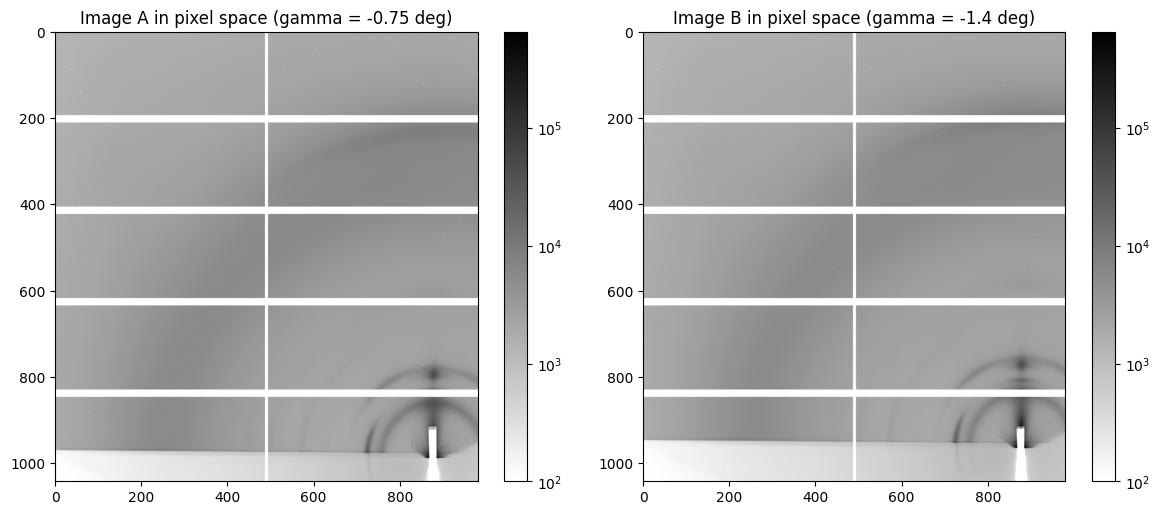

In [3]:
# Run this cell as is

# Play with the values of vmin and vmax to adjust contrast
colornorm = SymLogNorm(1, base=10, vmin=1e2, vmax=np.nanmax(img_A))

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first image
axes[0].imshow(img_A, origin='upper', cmap="gray_r", norm=colornorm)
axes[0].set_title('Image A in pixel space (gamma = -0.75 deg)')
fig.colorbar(plt.cm.ScalarMappable(norm=colornorm, cmap="gray_r"), ax=axes[0])

# Plot the second image
axes[1].imshow(img_B, origin='upper', cmap="gray_r", norm=colornorm)
axes[1].set_title('Image B in pixel space (gamma = -1.4 deg)')
fig.colorbar(plt.cm.ScalarMappable(norm=colornorm, cmap="gray_r"), ax=axes[1])

# Show the figure
plt.tight_layout()
plt.show()

# Beam parameters

In [4]:
# Modify with the beam parameters

# Common parameters
wavelength = 1.24 # in Angstrom
sample_detector_distance = 350 # in mm
PONIx = 563.5 # in pixel
PONIy = 1015 # in pixel
delta = -8.7 # in deg
incident_angle = 0.12 # in deg

# For each image
gamma_A = -0.75 # in deg
gamma_B = -1.4 # in deg

# Conversion to q-space

In [25]:
# Run this cell as is

# Set-up the geometry for each image
ai_A = pyFAI.load({"detector": pyFAI.detectors.Pilatus1M(), "wavelength": wavelength*1e-10})
ai_A.setFit2D(sample_detector_distance, PONIx, PONIy)
ai_A.rot1 = delta*np.pi/180.
ai_A.rot2 = gamma_A*np.pi/180.

ai_B = pyFAI.load({"detector": pyFAI.detectors.Pilatus1M(), "wavelength": wavelength*1e-10})
ai_B.setFit2D(sample_detector_distance, PONIx, PONIy)
ai_B.rot1 = delta*np.pi/180.
ai_B.rot2 = gamma_B*np.pi/180.

# Integration method
m = IntegrationMethod.select_method(dim=2, split="no", algo="CSR")[0]

# Define the units
unit_qip = get_unit_fiber(name="qip_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)
unit_qoop = get_unit_fiber(name="qoop_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)
unit_qx = get_unit_fiber(name="qxgi_nm^-1", incident_angle=incident_angle*np.pi/180., tilt_angle=0., sample_orientation=3)

I_A, qip_A, qoop_A  = ai_A.integrate2d(img_A, npt_rad = int(1043*0.8), npt_azim = int(981*0.8), method=m, unit=(unit_qip, unit_qoop))
I_B, qip_B, qoop_B = ai_B.integrate2d(img_B, npt_rad = int(1043*0.8), npt_azim = int(981*0.8), method=m, unit=(unit_qip, unit_qoop))


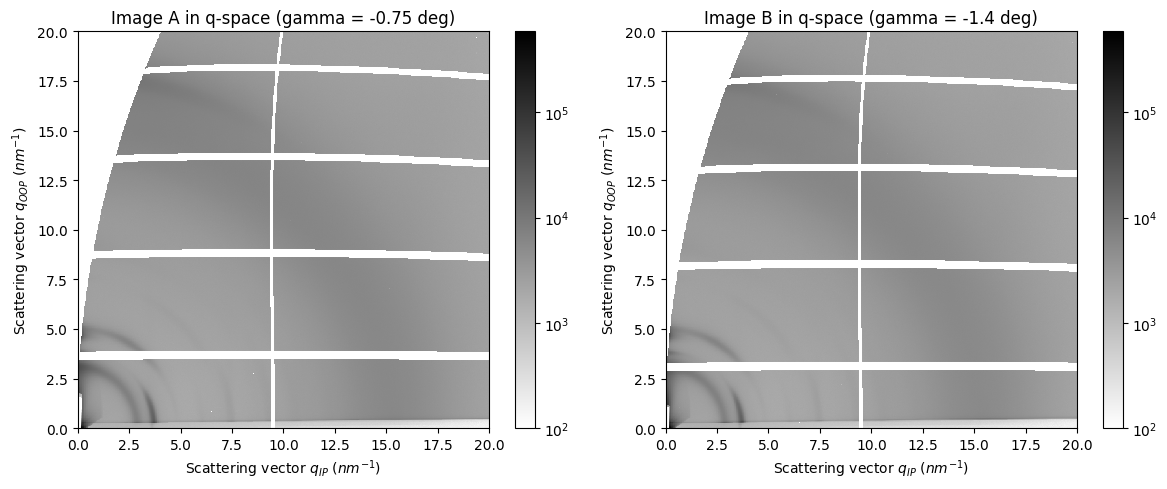

Images saved as PNG & TIFF. Data saved as .dat files with headers.


In [6]:
# Modify only the maximum q you want to reach in the images, and run the cell
max_qip = 20 #in-plane, in 1/nm
max_qoop = 20 #out-of-plane, in 1/nm

# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=1e2, vmax=np.nanmax(I_A))

# Create figure and axes for side-by-side images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Image A in q-space
cbar_A = axes[0].pcolormesh(qip_A, qoop_A, I_A, cmap="gray_r", norm=colornorm)
axes[0].set_xlim(0, max_qip)
axes[0].set_ylim(0, max_qoop)
axes[0].set_xlabel(unit_qip.label)
axes[0].set_ylabel(unit_qoop.label)
axes[0].set_title('Image A in q-space (gamma = -0.75 deg)')
fig.colorbar(cbar_A, ax=axes[0])

# Plot Image B in q-space
cbar_B = axes[1].pcolormesh(qip_B, qoop_B, I_B, cmap="gray_r", norm=colornorm)
axes[1].set_xlim(0, max_qip)
axes[1].set_ylim(0, max_qoop)
axes[1].set_xlabel(unit_qip.label)
axes[1].set_ylabel(unit_qoop.label)
axes[1].set_title('Image B in q-space (gamma = -1.4 deg)')
fig.colorbar(cbar_B, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("images_qspace.png", dpi=300)  # Save both images together
plt.show()

# Save I_A and I_B as TIFF images using PIL
Image.fromarray(I_A.astype(np.float32)).save("I_A.tiff")
Image.fromarray(I_B.astype(np.float32)).save("I_B.tiff")

# Save qip and qoop data with headers
header_qip = f"# {unit_qip.label} values"
header_qoop = f"# {unit_qoop.label} values"

np.savetxt("qip_A.dat", qip_A, header=header_qip, comments="")
np.savetxt("qoop_A.dat", qoop_A, header=header_qoop, comments="")

np.savetxt("qip_B.dat", qip_B, header=header_qip, comments="")
np.savetxt("qoop_B.dat", qoop_B, header=header_qoop, comments="")

print("Images saved as PNG & TIFF. Data saved as .dat files with headers.")

Do in two theta as well

# Powder plot

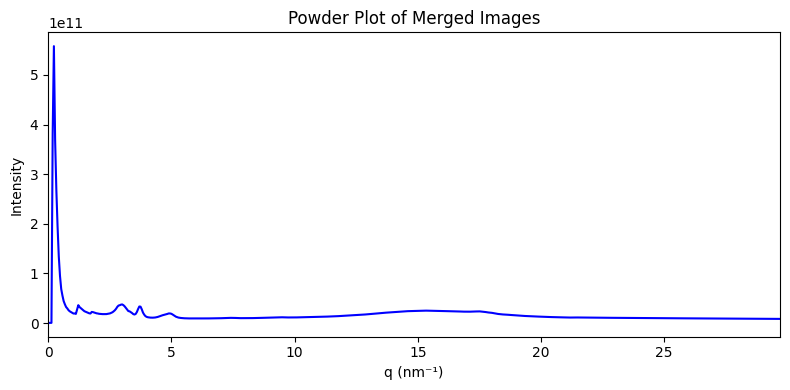

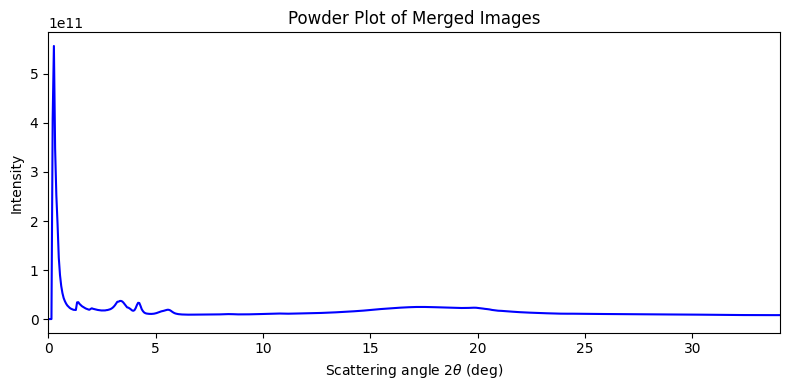

Image saved as PNG. Data saved as .dat files with headers.


In [7]:
# Modify only the number of data points you want in the powder plots, and run the cell

npt = 600

######## In q space #############

# Powder plot after merging
mg = MultiGeometry([ai_A, ai_B], unit="q_nm^-1", azimuth_range=(-180, -90))
q_AB, Iq_AB = mg.integrate1d([img_A, img_B], npt = npt, method=("no", "histogram", "cython"))

"""
# Uncomment if you plan to use individual images
# Powder plot of individual images
q_A, Iq_A = ai_A.integrate1d(img_A, npt = npt, azimuth_range=(-180, -90), 
                           unit="q_nm^-1", method=("no", "histogram", "cython"))

q_B, Iq_B = ai_B.integrate1d(img_B, npt = npt, azimuth_range=(-180, -90), 
                           unit="q_nm^-1", method=("no", "histogram", "cython"))
"""

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot I_A and I_B on the primary y-axis (left)
plt.plot(q_AB, Iq_AB, 'b-')
plt.xlabel("q (nm⁻¹)")
plt.ylabel("Intensity")
plt.xlim(0, np.max(q_AB))

# Adjust layout and save the figure
plt.title("Powder Plot of Merged Images")
plt.tight_layout()
plt.savefig("powder_plot_q.png", dpi=300)
plt.show()

# Save q_AB, and corresponding I values as .dat files with headers
np.savetxt("powder_q_AB.dat", np.column_stack((q_AB, Iq_AB)), header="# q_AB (nm^-1)   I_AB", comments="")

######## In 2 theta space #############

"""
# Uncomment if you plan to use individual images
# Powder plot of individual images
tth_A, Itth_A = ai_A.integrate1d(img_A, npt = npt, azimuth_range=(-180, -90), 
                           unit="2th_deg", method=("no", "histogram", "cython"))

tth_B, Itth_B = ai_B.integrate1d(img_B, npt = npt, azimuth_range=(-180, -90), 
                           unit="2th_deg", method=("no", "histogram", "cython"))
"""

# Powder plot after merging
mg = MultiGeometry([ai_A, ai_B], unit="2th_deg", azimuth_range=(-180, -90))
tth_AB, Itth_AB = mg.integrate1d([img_A, img_B], npt = npt,method=("no", "histogram", "cython"))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot I_A and I_B on the primary y-axis (left)
plt.plot(tth_AB, Itth_AB, 'b-')
plt.xlabel(r"Scattering angle 2$\theta$ (deg)")
plt.ylabel("Intensity")
plt.xlim(0, np.max(tth_AB))

# Adjust layout and save the figure
plt.title("Powder Plot of Merged Images")
plt.tight_layout()
plt.savefig("powder_plot_tth.png", dpi=300)
plt.show()

# Save tth_AB, and corresponding I values as .dat files with headers
np.savetxt("powder_tth_AB.dat", np.column_stack((tth_AB, Itth_AB)), header="# tth_AB (deg)   I_AB", comments="")

print("Image saved as PNG. Data saved as .dat files with headers.")

# 2D integration

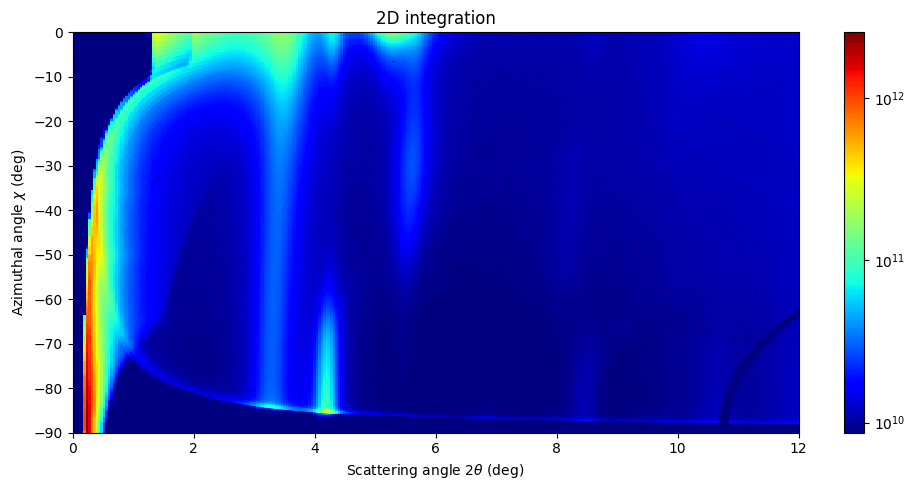

Images saved as PNG & TIFF. Data saved as .dat files with headers.


In [8]:
# Modify only the maximum 2_theta you want to reach in the image, and run the cell
max_tth = 12 #in-plane, in deg

# You may want to adjust the color scale of the image as well (vmin, vmax).

######## 2D integration #############
"""
# Uncomment if you plan to use individual images
# Powder plot of individual images
I_A, tth_A, chi_A  = ai_A.integrate2d(img_A, int(1043*0.8), int(981*0.8),
                           azimuth_range=(-180, -90), 
                           unit="2th_deg")

I_B, tth_B, chi_B  = ai_B.integrate2d(img_B, int(1043*0.8), int(981*0.8),
                           azimuth_range=(-180, -90), 
                           unit="2th_deg")
"""
# After merging
mg = MultiGeometry([ai_A, ai_B], unit="2th_deg", azimuth_range=(-180, -90))
I_AB, tth_AB, chi_AB  = mg.integrate2d([img_A, img_B], int(1043*0.8), int(981*0.8))


# Phase chi so that 0 in on the beamstop, -90 on the horizon
chi_AB = chi_AB + 90

# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=np.nanpercentile(I_AB, 25), vmax=np.nanmax(I_AB))

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cbar_AB = ax.pcolormesh(tth_AB, chi_AB, I_AB, cmap="jet", norm=colornorm)
ax.set_xlim(0, max_tth)
ax.set_ylim(-90, 0)
ax.set_xlabel(r"Scattering angle 2$\theta$ (deg)")
ax.set_ylabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_title('2D integration')
fig.colorbar(cbar_AB, ax=ax)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("image_2D_integration.png", dpi=300)
plt.show()

# Save I_AB as TIFF image using PIL
Image.fromarray(I_AB.astype(np.float32)).save("I_2D_integration.tiff")

# Save tth and chi data with headers
header_tth = f"# Scattering angle 2$\theta$ (deg)"
header_chi = f"# Azimuthal angle $\chi$ (deg)"

np.savetxt("tth_2D_integration.dat", tth_AB, header=header_tth, comments="")
np.savetxt("chi_2D_integration.dat", chi_AB, header=header_chi, comments="")

print("Images saved as PNG & TIFF. Data saved as .dat files with headers.")

# Radial integration & Pole figure

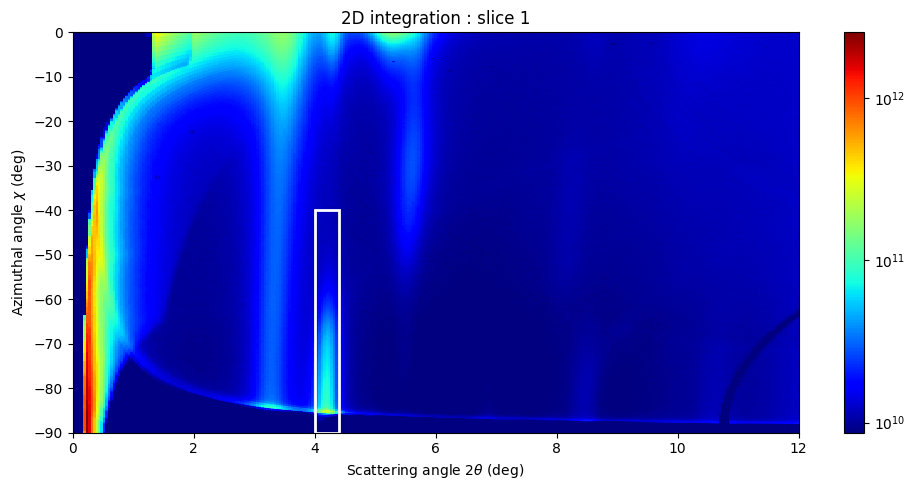

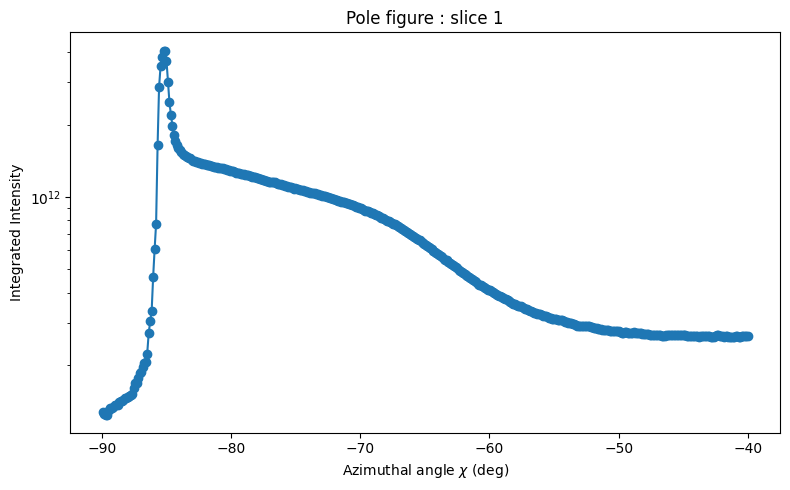

Image saved as PNG. Data saved as .dat files with headers.


In [9]:
# Modify only the limits for the integration, and run the cell.

# Define the left and right boundaries for selection (modify these values)
left_tth = 4.    # Set your desired left boundary (in degrees)
right_tth = 4.4  # Set your desired right boundary (in degrees)
# Define the top and bottom chi boundaries
bottom_chi = -90   # Bottom boundary (in degrees)
top_chi = -40      # Top boundary (in degrees)


# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

rect = patches.Rectangle((left_tth, bottom_chi),  # Bottom-left corner
                         right_tth - left_tth,    # Width (2θ range)
                         top_chi - bottom_chi,    # Height (Chi range)
                         linewidth=2, edgecolor='white', facecolor='none')

cbar_AB = ax.pcolormesh(tth_AB, chi_AB, I_AB, cmap="jet", norm=colornorm)
ax.set_xlim(0, max_tth)
ax.set_ylim(-90, 0)
ax.set_xlabel(r"Scattering angle 2$\theta$ (deg)")
ax.set_ylabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_title('2D integration : slice 1')
ax.add_patch(rect) 
fig.colorbar(cbar_AB, ax=ax)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("image_2D_integration_slice_1.png", dpi=300)
plt.show()

### Pole figure ###

# Find the indices corresponding to the selected 2θ and χ range
tth_mask = (tth_AB >= left_tth) & (tth_AB <= right_tth)
chi_mask = (chi_AB >= bottom_chi) & (chi_AB <= top_chi)

# Select the intensity values within the rectangle
I_selected = I_AB[np.ix_(chi_mask, tth_mask)]  # Subset selection

# Integrate along the 2θ axis
integrated_intensity = np.sum(I_selected, axis=1)/np.abs(left_tth-right_tth)  # Normalized by the width

# Select the chi values corresponding to the selection
chi_selected = chi_AB[chi_mask]

# Plot Integrated Intensity vs. Chi
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(chi_selected, integrated_intensity, marker='o', linestyle='-')
ax.set_yscale('log')

ax.set_xlabel(r"Azimuthal angle $\chi$ (deg)")
ax.set_ylabel("Integrated Intensity")
ax.set_title("Pole figure : slice 1")

plt.tight_layout()
plt.savefig("pole_fig_slice_1.png", dpi=300)
plt.show()

# Save as .dat files with headers
np.savetxt("pole_fig_slice_1.dat", np.column_stack((chi_selected, integrated_intensity)), header="# chi (deg)   I", comments="")

print("Image saved as PNG. Data saved as .dat files with headers.")

# In-plane & out-of-plane integration

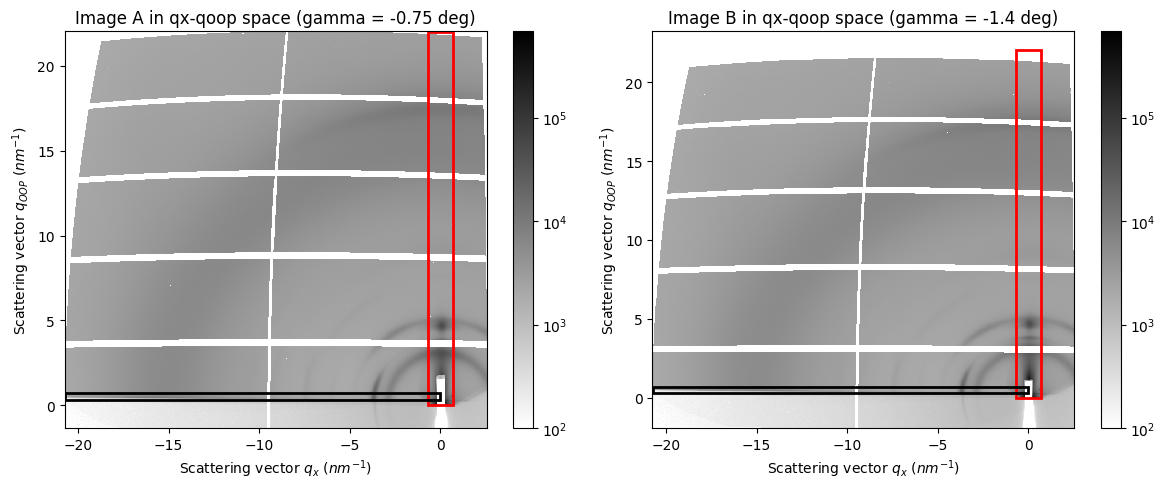

In [78]:
# Define the left and right boundaries for the in-plane integration
# -> Red rectangle
left_qx = -0.7    # Set your desired left boundary (in nm^-1)
right_qx = 0.7  # Set your desired right boundary (in nm^-1)

# Define the bottom and top boundaries for the out-of-plane integration
# -> Black rectangle
bottom_qoop = 0.3   # Bottom boundary (in nm^-1)
top_qoop = 0.7      # Top boundary (in nm^-1)


I_A, qx_A, qoop_A = ai_A.integrate2d(img_A, npt_rad = int(1043*0.8), npt_azim = int(981*0.8),
                                     method=m, unit=("qxgi_nm^-1", "qoop_nm^-1"))
I_B, qx_B, qoop_B = ai_B.integrate2d(img_B, npt_rad = int(1043*0.8), npt_azim = int(981*0.8),
                                     method=m, unit=("qxgi_nm^-1", "qoop_nm^-1"))

# Define color normalization
colornorm = SymLogNorm(1, base=10, vmin=1e2, vmax=np.nanmax(I_A))

# Create figure and axes for side-by-side images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

rect_red = patches.Rectangle((left_qx, 0),  # Bottom-left corner
                         right_qx - left_qx,    # Width
                         np.abs(np.max(qoop_A) - 0),    # Height
                         linewidth=2, edgecolor='red', facecolor='none')

rect_black = patches.Rectangle((np.min(qx_A), bottom_qoop),  # Bottom-left corner
                         np.abs(np.min(qx_A) - 0),    # Width
                         top_qoop - bottom_qoop,    # Height
                         linewidth=2, edgecolor='black', facecolor='none')

# Plot Image A in q-space
cbar_A = axes[0].pcolormesh(qx_A, qoop_A, I_A, cmap="gray_r", norm=colornorm)
axes[0].set_xlabel(unit_qx.label)
axes[0].set_ylabel(unit_qoop.label)
axes[0].set_title('Image A in qx-qoop space (gamma = -0.75 deg)')
axes[0].add_patch(rect_red) 
axes[0].add_patch(rect_black) 

fig.colorbar(cbar_A, ax=axes[0])

rect_red = patches.Rectangle((left_qx, 0),  # Bottom-left corner
                         right_qx - left_qx,    # Width
                         np.abs(np.max(qoop_A) - 0),    # Height
                         linewidth=2, edgecolor='red', facecolor='none')

rect_black = patches.Rectangle((np.min(qx_A), bottom_qoop),  # Bottom-left corner
                         np.abs(np.min(qx_A) - 0),    # Width
                         top_qoop - bottom_qoop,    # Height
                         linewidth=2, edgecolor='black', facecolor='none')

# Plot Image B in q-space
cbar_B = axes[1].pcolormesh(qx_B, qoop_B, I_B, cmap="gray_r", norm=colornorm)
axes[1].set_xlabel(unit_qx.label)
axes[1].set_ylabel(unit_qoop.label)
axes[1].add_patch(rect_red) 
axes[1].add_patch(rect_black) 
axes[1].set_title('Image B in qx-qoop space (gamma = -1.4 deg)')
fig.colorbar(cbar_B, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("images_qspace_ip_oop_integration.png", dpi=300)  # Save both images together
plt.show()

plt.show()


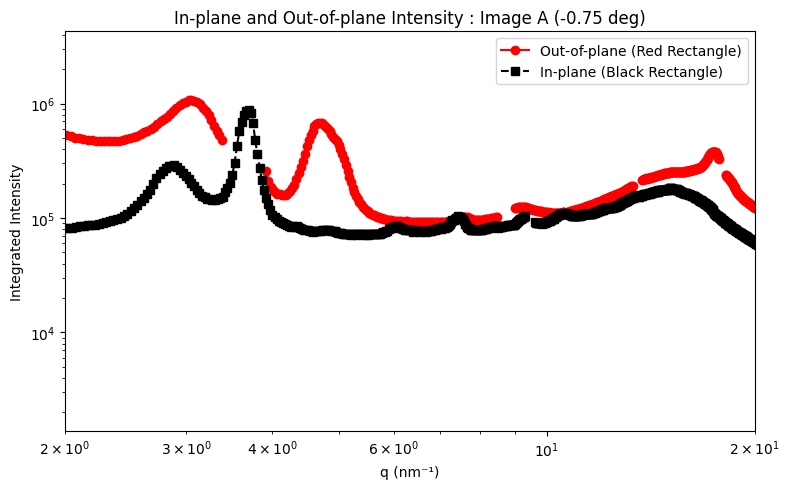

Comparison plot saved as PNG.


In [61]:

# -----------------------------
# INTEGRATION OVER RECTANGLES
# -----------------------------

# Red Rectangle: Integration along qx (summed over qx range)
qx_mask = (qx_A >= left_qx) & (qx_A <= right_qx)
I_red_A = np.sum(I_A[:, qx_mask], axis=1)/np.abs(left_qx-right_qx)  # Summing over qx
qoop_selected_A = qoop_A  # Keeping qoop axis

## Remove pixels around dead zones
# Find indices where I_red is exactly 0
zero_indices = np.where(I_red_A == 0)[0]

# Expand selection before and after, ensuring we stay within array bounds
nan_indices = np.unique(np.concatenate([
    zero_indices,
    zero_indices - 2,  # One before
    zero_indices + 2   # One after
]))

# Ensure indices are within valid bounds
nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_red_A))]

# Replace selected indices with NaN
I_red_A[nan_indices] = np.nan

##

# Black Rectangle: Integration along qoop (summed over qoop range)
qoop_mask = (qoop_A >= bottom_qoop) & (qoop_A <= top_qoop)
I_black_A = np.sum(I_A[qoop_mask, :], axis=0)/np.abs(bottom_qoop-top_qoop)  # Summing over qoop
qx_selected_A = -qx_A  # Keeping qx axis

## Remove pixels around dead zones
# Find indices where I_red is exactly 0
zero_indices = np.where(I_black_A == 0)[0]

# Expand selection before and after, ensuring we stay within array bounds
nan_indices = np.unique(np.concatenate([
    zero_indices,
    zero_indices - 2,  # One before
    zero_indices + 2   # One after
]))

# Ensure indices are within valid bounds
nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_black_A))]

# Replace selected indices with NaN
I_black_A[nan_indices] = np.nan

##

# -----------------------------
# PLOT COMPARISON
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_A, I_red_A, color='red', marker='o', linestyle='-', label='Out-of-plane (Red Rectangle)')
ax.plot(qx_selected_A, I_black_A, color='black', marker='s', linestyle='--', label='In-plane (Black Rectangle)')

ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(2,20)
ax.set_title("In-plane and Out-of-plane Intensity : Image A (-0.75 deg)")
ax.legend()

plt.tight_layout()
plt.savefig("integrated_intensity_comparison_img_A.png", dpi=300)
plt.show()

print("Comparison plot saved as PNG.")

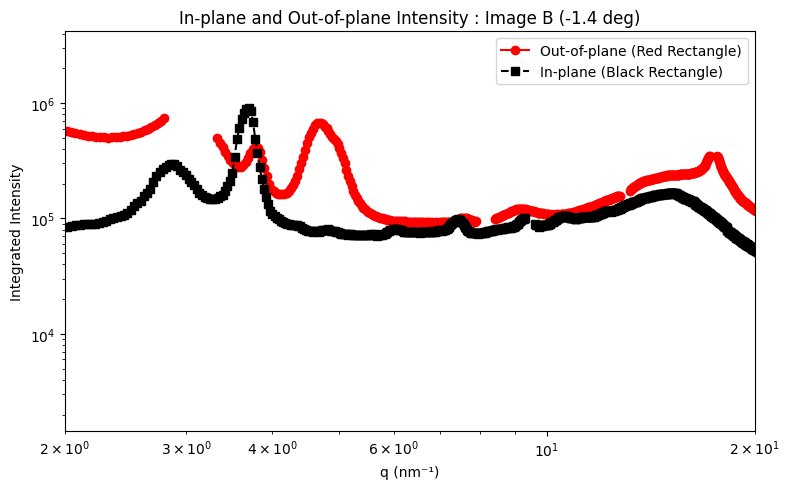

Comparison plot saved as PNG.


In [63]:

# -----------------------------
# INTEGRATION OVER RECTANGLES
# -----------------------------

# Red Rectangle: Integration along qx (summed over qx range)
qx_mask = (qx_B >= left_qx) & (qx_B <= right_qx)
I_red_B = np.sum(I_B[:, qx_mask], axis=1)/np.abs(left_qx-right_qx)  # Summing over qx
qoop_selected_B = qoop_B  # Keeping qoop axis

## Remove pixels around dead zones
# Find indices where I_red is exactly 0
zero_indices = np.where(I_red_B == 0)[0]

# Expand selection before and after, ensuring we stay within array bounds
nan_indices = np.unique(np.concatenate([
    zero_indices,
    zero_indices - 2,  # One before
    zero_indices + 2   # One after
]))

# Ensure indices are within valid bounds
nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_red_B))]

# Replace selected indices with NaN
I_red_B[nan_indices] = np.nan

##

# Black Rectangle: Integration along qoop (summed over qoop range)
qoop_mask = (qoop_B >= bottom_qoop) & (qoop_B <= top_qoop)
I_black_B = np.sum(I_B[qoop_mask, :], axis=0)/np.abs(bottom_qoop-top_qoop)  # Summing over qoop
qx_selected_B = -qx_B  # Keeping qx axis

## Remove pixels around dead zones
# Find indices where I_red is exactly 0
zero_indices = np.where(I_black_B == 0)[0]

# Expand selection before and after, ensuring we stay within array bounds
nan_indices = np.unique(np.concatenate([
    zero_indices,
    zero_indices - 2,  # One before
    zero_indices + 2   # One after
]))

# Ensure indices are within valid bounds
nan_indices = nan_indices[(nan_indices >= 0) & (nan_indices < len(I_black_B))]

# Replace selected indices with NaN
I_black_B[nan_indices] = np.nan

##

# -----------------------------
# PLOT COMPARISON
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_B, I_red_B, color='red', marker='o', linestyle='-', label='Out-of-plane (Red Rectangle)')
ax.plot(qx_selected_B, I_black_B, color='black', marker='s', linestyle='--', label='In-plane (Black Rectangle)')

ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(2,20)
ax.set_title("In-plane and Out-of-plane Intensity : Image B (-1.4 deg)")
ax.legend()

plt.tight_layout()
plt.savefig("integrated_intensity_comparison_img_B.png", dpi=300)
plt.show()

print("Comparison plot saved as PNG.")

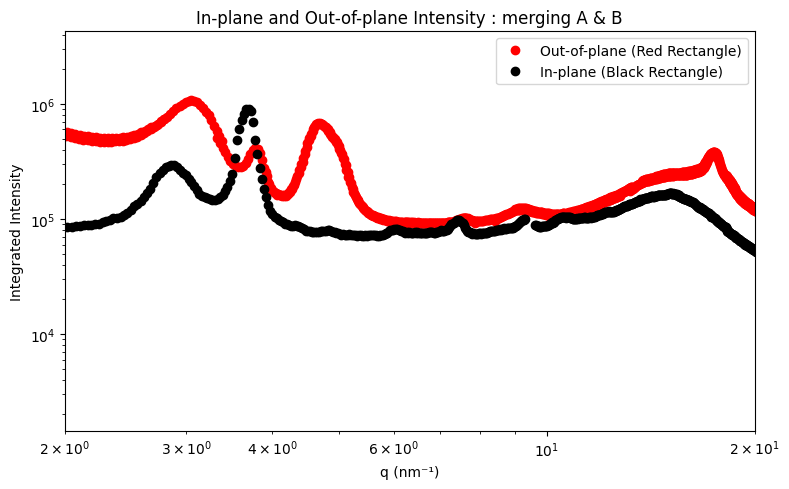

Comparison plot saved as PNG.


In [77]:

# -----------------------------
# PLOT COMPARISON
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(qoop_selected_B, I_red_B, 'ro', label='Out-of-plane (Red Rectangle)')
ax.plot(qoop_selected_A, I_red_A, 'ro')

ax.plot(qx_selected_B, I_black_B, 'ko', label='In-plane (Black Rectangle)')


ax.set_xlabel("q (nm⁻¹)")
ax.set_ylabel("Integrated Intensity")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(2,20)
ax.set_title("In-plane and Out-of-plane Intensity : merging A & B")
ax.legend()

plt.tight_layout()
plt.savefig("integrated_intensity_comparison_img_A_B.png", dpi=300)
plt.show()

print("Comparison plot saved as PNG.")